## TODOs

In [17]:
import analyze
import prep
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from prep import text_clean
import altair as alt
from altair_saver import save
%load_ext rpy2.ipython

%load_ext autoreload
%autoreload 2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_PATH = "../data/2020/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
outcome = "Wage"
data_2020, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2020)

DATA_PATH = "../data/2019/survey_results_public.csv"
data_raw = pd.read_csv(DATA_PATH)
data_2019, keep, groups, categorical, numeric, base = prep.prep(data_raw, outcome, 2019)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Removing 0 respondents with missing Wage
6284 developers left in the sample after cleaning
151 or 2.4% black developers in the sample with multiracial replacement
Removing 0 respondents with missing Wage
12502 developers left in the sample after cleaning
291 or 2.3% black developers in the sample with multiracial replacement


In [246]:
data = pd.concat([data_2020, data_2019], axis=0)

In [247]:
X, Y = prep.design_matrix(data, categorical, numeric, base, outcome)

Design matrix complete with 184 variables/columns


In [248]:
data["Ethnicity_Black_or_of_African_descent"] = data["Ethnicity"] == "Black or of African descent"

In [249]:
breakdown = ["DevType", "OrgSize", "Gender"]

In [250]:
for column in breakdown:
    for col in sorted(set([i for row in data[column].str.split(";") for i in row])):            
                # Create control columns
                data[column+"_"+text_clean(col)] = data[column].str.split(";").map(lambda x: col in x)

    data = data.drop([column], axis=1)

In [251]:
representation = {}

for column in breakdown:
    types = []
    
    for col in [col for col in data.columns if column in col]:
        types.append(data.loc[data[col] == 1]["Ethnicity_Black_or_of_African_descent"].mean())
    
    representation[column] = pd.Series(types, index=[col[len(column)+1:] for col in data.columns if column in col]
                                      ).sort_values(ascending=False).drop("No_answer").reset_index()
    
    representation[column] = representation[column].rename(columns={"index": "labels", 0: "data"})

In [252]:
representation["DevType"] = representation["DevType"].loc[(representation["DevType"]["labels"] != "Marketing_or_sales_professional") & \
                                                          (representation["DevType"]["labels"] != "Student")]

representation["DevType"]["labels"] = ["Educator", 
                                       "Mobile",
                                       "Designer",
                                       "Front-end",
                                       "Full-stack",
                                       "QA / Test",
                                       "Data engineer",
                                       "Desktop / Enterprise apps",
                                       "Executive",
                                       "Back-end",
                                       "Embedded apps / devices",
                                       "Data / Business analyst",
                                       "Site reliability",
                                       "Engineering manager",
                                       "Games / Graphics",
                                       "System admnistrator",
                                       "Scientist",
                                       "Database administrator",
                                       "Data scientist",
                                       "Product manager",
                                       "DevOps",
                                       "Academic researcher"]

representation["DevType"]["average"] = 0.025

In [267]:
representation["Gender"]["labels"] = ["Women", "Non-binary", "Men"]

In [263]:
points = alt.Chart().mark_bar(cornerRadiusBottomRight=8, cornerRadiusTopRight=8, clip=True, color="#612b8a").encode(
    x=alt.X("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=5, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    y=alt.Y("labels", 
            axis=alt.Axis(title=None, labelFontSize=15), sort="-x"
           ),
    color=alt.Color("data", 
                    scale=alt.Scale(scheme="inferno", domain=[0.005, 0.04]),
                    legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=0,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x="data",
    y=alt.Y("labels", sort="-x"),
)

chart = alt.layer(points, text, data=representation["DevType"]).properties(
    width=400,
    height=500,
    title={
        "text": "Representation by Role", 
        "subtitle": "% Black, Respondents can select multiple roles",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("representation_role.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

In [262]:
points = alt.Chart().mark_bar(size=55, cornerRadiusTopLeft=8, cornerRadiusTopRight=8, clip=True).encode(
    x=alt.X("YearsCodePro",
            axis=alt.Axis(title=None, labelFontSize=15),
            scale=alt.Scale(
                domain=(0, 40)
            ),
           bin=alt.Bin(extent=[0, 40], step=5)),
    y=alt.Y("mean(Ethnicity_Black_or_of_African_descent)",
            axis=alt.Axis(format=".1%", title=None, tickCount=4, tickSize=0, labelFlush=False, labelFontSize=15),
            scale=alt.Scale(
                domain=(0, 0.04)
            )
           ),
    color=alt.Color("mean(Ethnicity_Black_or_of_African_descent)", 
                    scale=alt.Scale(scheme="inferno", domain=[0, 0.05]),
                    legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=-15,
    dy=-15,
    fontSize=15
).encode(
    text=alt.Text("mean(Ethnicity_Black_or_of_African_descent)", format=".1%"),
    x=alt.X("YearsCodePro",
           bin=alt.Bin(extent=[0, 40], step=5)),
    y=alt.Y("mean(Ethnicity_Black_or_of_African_descent)"),
)

chart = alt.layer(points, text, data=data.groupby("YearsCodePro").mean()["Ethnicity_Black_or_of_African_descent"].reset_index()).properties(
    width=500,
    height=300,
    title={
        "text": "Representation by Years of Experience", 
        "subtitle": "% Black, 5-Year Bins",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("representation_experience.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

In [274]:
points = alt.Chart().mark_bar(cornerRadiusBottomRight=8, cornerRadiusTopRight=8, clip=True, color="#612b8a").encode(
    x=alt.X("data", 
            axis=alt.Axis(format=".1%", title=None, tickCount=5, tickSize=0, labelFlush=False, labelFontSize=15),
    ),
    y=alt.Y("labels", 
            axis=alt.Axis(title=None, labelFontSize=15), sort="-x"
           ),
    color=alt.Color("data", 
                scale=alt.Scale(scheme="inferno", domain=[0.005, 0.08]),
                legend=None)
)

text = alt.Chart().mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=0,
    fontSize=15
).encode(
    text=alt.Text("data", format=".1%"),
    x="data",
    y=alt.Y("labels", sort="-x"),
)

chart = alt.layer(points, text, data=representation["Gender"]).properties(
    width=400,
    height=500,
    title={
        "text": "Representation by Gender", 
        "subtitle": "% Black",
        "subtitleColor": "gray"
    }
).configure_view(
    strokeWidth=0
).configure_title(
    anchor='start',
    offset=5,
    fontSize=20
).configure_axis(
    domain=False
)

chart.save("representation_gender.png", method="selenium", webdriver="chrome", scale_factor=3.0)

chart

alt.LayerChart(...)

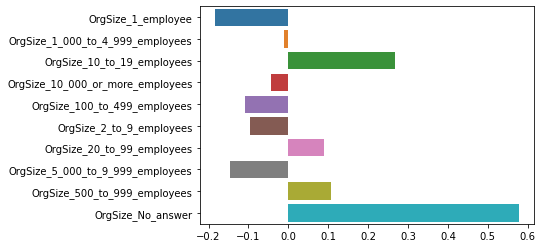

In [131]:
sns.barplot(x=representation["OrgSize"]-1, y=representation["OrgSize"].index)
plt.show()